In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append("../../../../src/")
import nanonets
import nanonets_utils

import scienceplots
from matplotlib.colors import LogNorm, Normalize
from matplotlib.cm import ScalarMappable
plt.style.use(["science","bright","grid"])
%matplotlib inline


# Global
N_PERIODS   = 40
AMPLITUDES  = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2]
TEMPERATURE = [1.0,2.0,4.0,8.0,16.0,32.0,64.0,128.0,256.0,512.0]
EPS_S       = 3.9
EPS_R       = 2.6
cm          = plt.get_cmap('cividis')

def return_voltages(amp, f_0=1e5):
    
    # Time
    dt      = 1 / (40*f_0)
    N       = int(np.ceil((N_PERIODS / f_0) / dt))
    t       = np.arange(N)*dt

    # Volt
    U_0     = amp*np.cos(2*np.pi*f_0*t)
    U_1     = np.repeat(0,N)
    U       = np.zeros(shape=(N,3))
    U[:,0]  = U_0
    U[:,1]  = U_1

    return t, U

### 2 NP Device of equal NP-Size

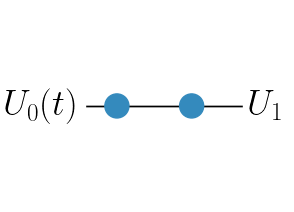

In [5]:
topo = {
    "Nx":               2,
    "Ny":               1,
    "Nz":               1,
    "e_pos":            [[0, 0, 0], [1, 0, 0]],
    "electrode_type":   ['constant', 'constant']
}
sim     = nanonets.simulation(topo)
fig,ax  = nanonets_utils.display_network(sim, provide_electrode_labels=['$U_0(t)$','$U_1$'], font_size=26)

In [31]:
C_mat   = sim.return_capacitance_matrix()
ele     = sim.ele_charge
E_sgl   = 0.5*ele*ele/np.diag(C_mat)
U_sgl   = ele / np.diag(C_mat)
print(E_sgl)
print(U_sgl)

[0.00145673 0.00145673]
[0.01818445 0.01818445]


In [32]:
C_inv   = sim.return_inv_capacitance_matrix()
ele     = sim.ele_charge
E_sgl   = ele*ele*np.diag(C_inv)/2
U_sgl   = ele*np.diag(C_inv)
print(E_sgl)
print(U_sgl)

[0.00155698 0.00155698]
[0.01943587 0.01943587]


In [22]:
E_sgl

array([0.10580282, 0.10580282])

In [24]:
V_th

array([0.66036924, 0.66036924])

(0.0, 50000.0)

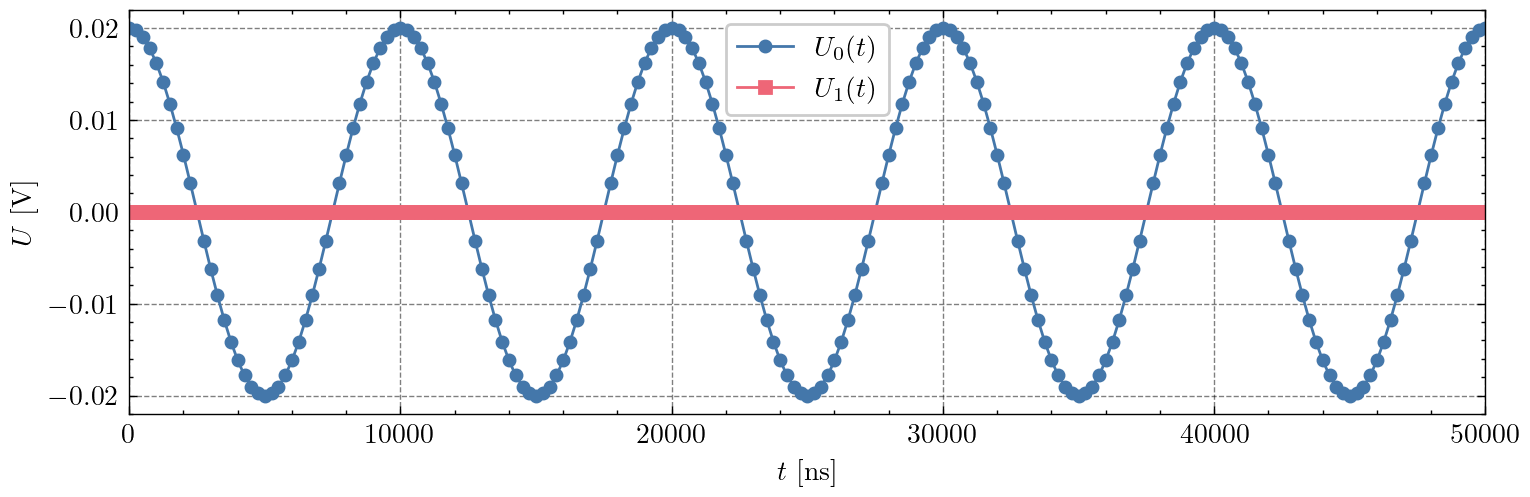

In [3]:
t,U = return_voltages(0.02)
U_0 = U[:,0]    
U_1 = U[:,1]    

fig,ax = plt.subplots(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2.5)
ax.plot(t*1e9, U_0, '-o', label='$U_0(t)$', ms=4)
ax.plot(t*1e9, U_1, '-s', label='$U_1(t)$', ms=4)
ax.set_ylabel("$U$ [V]")
ax.set_xlabel("$t$ [ns]")
ax.legend()
ax.set_xlim(0,5e4)

### Amplitude dependence

In [4]:
results_dict  = {}
pots_dict     = {}
pots_d_dict   = {}
currents_dict = {}
time_dict     = {}

for amp in AMPLITUDES:

    # Voltages
    t,U = return_voltages(amp)

    # Simulation
    sim.run_var_voltages(voltages=U, time_steps=t, target_electrode=1, T_val=5.0, save=False, stat_size=20)

    # Results
    results = pd.DataFrame(sim.return_output_values()[:,1:], columns=['steps','I','u_I'])
    pots    = pd.DataFrame(sim.return_potential_landscape())
    a, b    = sim.return_network_currents()
    currs   = pd.DataFrame(b, columns=a)
    currents_dict[amp] = currs

    time_dict[amp]      = t
    results_dict[amp]   = results
    pots_dict[amp]      = pots
    pots_diffs          = pots.iloc[:,[0,2,3,1]].copy()
    pots_diffs.columns  = [0,1,2,3]
    pots_diffs          = pots_diffs.diff(axis=1).dropna(axis=1)
    pots_d_dict[amp]    = pots_diffs

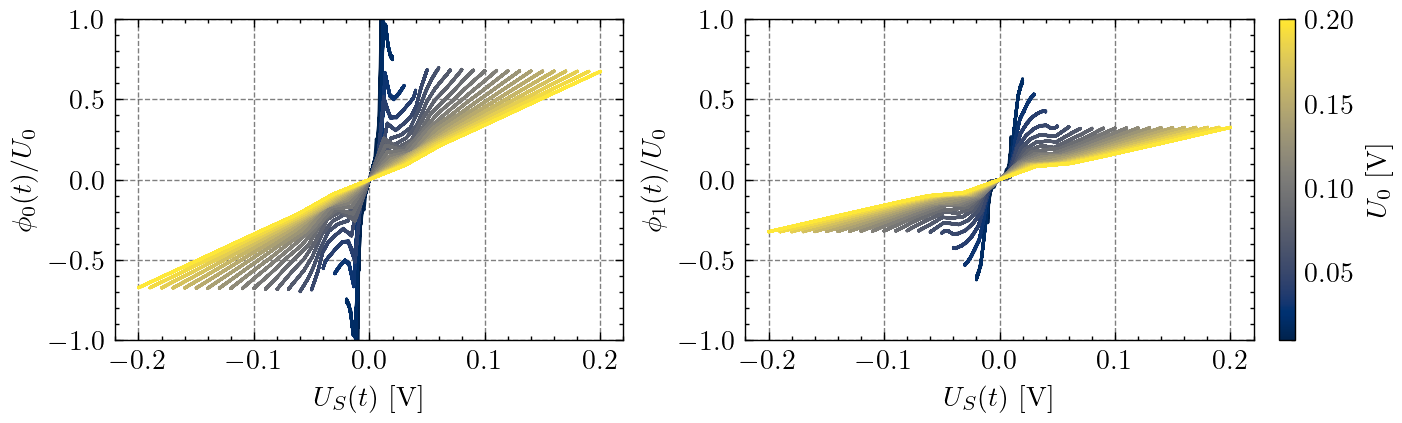

In [5]:
norm = Normalize(vmin=min(AMPLITUDES), vmax=max(AMPLITUDES))

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2.0)
fig.set_figheight(fig.get_figheight()*0.8)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

for amp in AMPLITUDES:
    ax1.plot(pots_dict[amp].iloc[1000:,0],pots_dict[amp].iloc[1000:,2]/amp, color=cm(norm(amp)))
    ax1.set_ylabel('$\phi_0(t)/U_0$')
    ax1.set_xlabel('$U_S(t)$ [V]')
    ax1.set_ylim(-1,1)

    ax2.plot(pots_dict[amp].iloc[1000:,0],pots_dict[amp].iloc[1000:,3]/amp, color=cm(norm(amp)))
    ax2.set_xlabel('$U_S(t)$ [V]')
    ax2.set_ylabel('$\phi_1(t)/U_0$')
    ax2.set_ylim(-1,1)

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax2)
cbar.set_label("$U_0$ [V]")

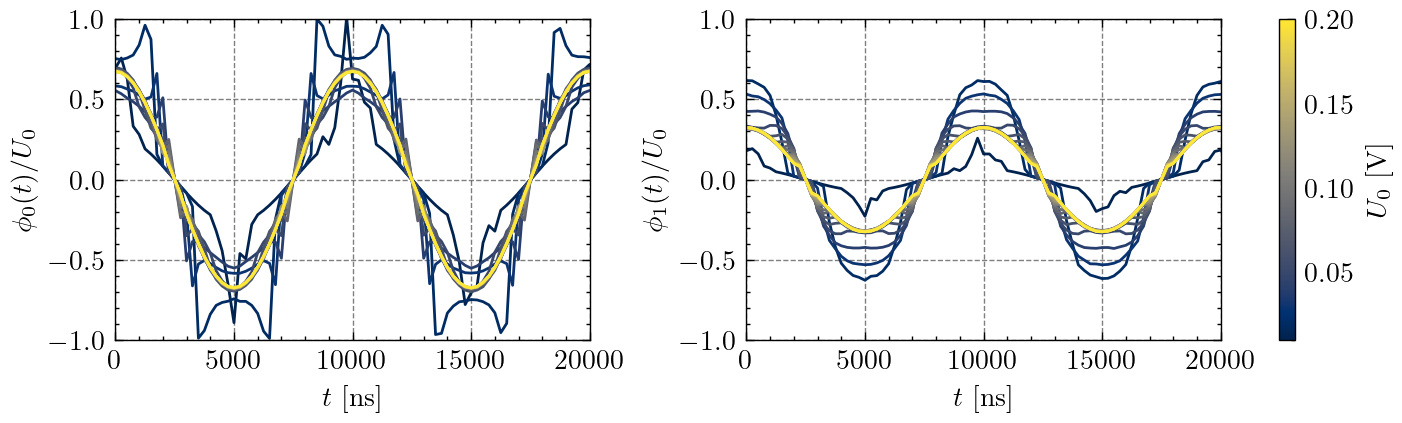

In [6]:
norm = Normalize(vmin=min(AMPLITUDES), vmax=max(AMPLITUDES))

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2.0)
fig.set_figheight(fig.get_figheight()*0.8)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

for amp in AMPLITUDES:
    ax1.plot(time_dict[amp][:-1]*1e9,pots_dict[amp].iloc[:,2]/amp, color=cm(norm(amp)))
    ax1.set_xlabel('$t$ [ns]')
    ax1.set_ylabel('$\phi_0(t)/U_0$')
    ax1.set_ylim(-1,1)
    ax1.set_xlim(0,2e4)

    ax2.plot(time_dict[amp][:-1]*1e9,pots_dict[amp].iloc[:,3]/amp, color=cm(norm(amp)))
    ax2.set_xlabel('$t$ [ns]')
    ax2.set_ylabel('$\phi_1(t)/U_0$')
    ax2.set_ylim(-1,1)
    ax2.set_xlim(0,2e4)

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax2)
cbar.set_label("$U_0$ [V]")

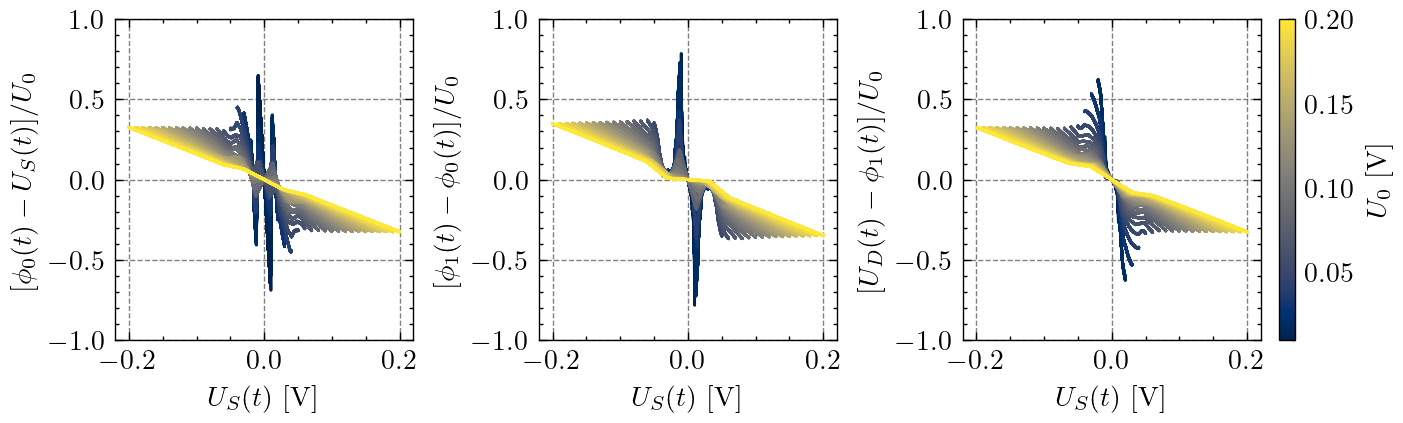

In [7]:
norm = Normalize(vmin=min(AMPLITUDES), vmax=max(AMPLITUDES))

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2.0)
fig.set_figheight(fig.get_figheight()*0.8)
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

for amp in AMPLITUDES:
    ax1.plot(pots_dict[amp].iloc[1000:,0], pots_d_dict[amp].iloc[1000:,0]/amp, color=cm(norm(amp)))
    ax1.set_ylabel('$[\phi_0(t)-U_S(t)]/U_0$')
    ax1.set_xlabel('$U_S(t)$ [V]')
    ax1.set_ylim(-1,1)

    ax2.plot(pots_dict[amp].iloc[1000:,0], pots_d_dict[amp].iloc[1000:,1]/amp, color=cm(norm(amp)))
    ax2.set_xlabel('$U_S(t)$ [V]')
    ax2.set_ylabel('$[\phi_1(t)-\phi_0(t)]/U_0$')
    ax2.set_ylim(-1,1)

    ax3.plot(pots_dict[amp].iloc[1000:,0], pots_d_dict[amp].iloc[1000:,2]/amp, color=cm(norm(amp)))
    ax3.set_xlabel('$U_S(t)$ [V]')
    ax3.set_ylabel('$[U_D(t)-\phi_1(t)]/U_0$')
    ax3.set_ylim(-1,1)

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax3)
cbar.set_label("$U_0$ [V]")

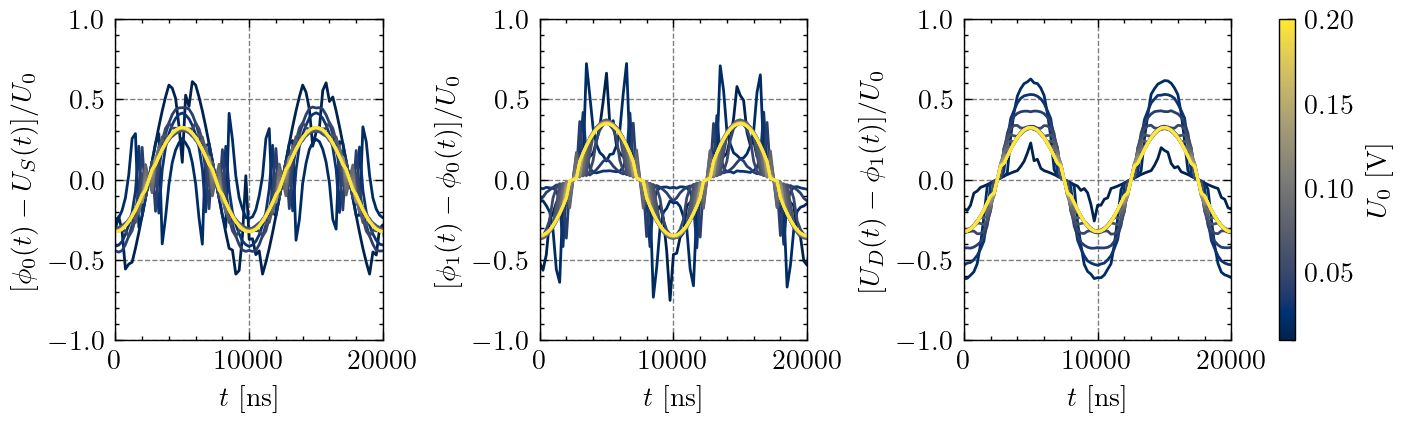

In [8]:
norm = Normalize(vmin=min(AMPLITUDES), vmax=max(AMPLITUDES))

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2.0)
fig.set_figheight(fig.get_figheight()*0.8)
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

for amp in AMPLITUDES:
    ax1.plot(time_dict[amp][:-1]*1e9, pots_d_dict[amp].iloc[:,0]/amp, color=cm(norm(amp)))
    ax1.set_ylabel('$[\phi_0(t)-U_S(t)]/U_0$')
    ax1.set_xlabel('$t$ [ns]')
    ax1.set_ylim(-1,1)
    ax1.set_xlim(0,2e4)

    ax2.plot(time_dict[amp][:-1]*1e9, pots_d_dict[amp].iloc[:,1]/amp, color=cm(norm(amp)))
    ax2.set_xlabel('$t$ [ns]')
    ax2.set_ylabel('$[\phi_1(t)-\phi_0(t)]/U_0$')
    ax2.set_ylim(-1,1)
    ax2.set_xlim(0,2e4)

    ax3.plot(time_dict[amp][:-1]*1e9, pots_d_dict[amp].iloc[:,2]/amp, color=cm(norm(amp)))
    ax3.set_xlabel('$t$ [ns]')
    ax3.set_ylabel('$[U_D(t)-\phi_1(t)]/U_0$')
    ax3.set_ylim(-1,1)
    ax3.set_xlim(0,2e4)

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax3)
cbar.set_label("$U_0$ [V]")### Amplitude dependence

In [45]:
amp = 0.01
currents_dict[amp][0] = currents_dict[amp][(0,2)]-currents_dict[amp][(2,0)]
currents_dict[amp][1] = currents_dict[amp][(2,3)]-currents_dict[amp][(3,2)]
currents_dict[amp][2] = currents_dict[amp][(3,1)]-currents_dict[amp][(1,3)]
currents_dict[amp]

,"(0, 2)","(1, 3)","(2, 0)","(2, 3)","(3, 1)","(3, 2)",0,1,2
0,0.224305,0.0,0.096131,0.128174,0.128174,0.0,0.128174,0.128174,0.128174
1,0.352479,0.0,0.192261,0.160218,0.160218,0.0,0.160218,0.160218,0.160218
2,0.224305,0.0,0.160218,0.064087,0.064087,0.0,0.064087,0.064087,0.064087
3,0.032044,0.0,0.000000,0.032044,0.032044,0.0,0.032044,0.032044,0.032044
4,0.032044,0.0,0.032044,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
1595,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1596,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1597,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1598,0.064087,0.0,0.064087,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


(0.0, 20000.0)

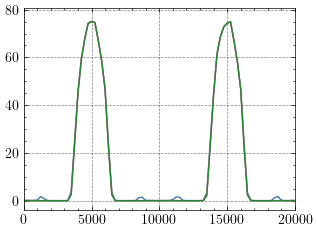

In [43]:
fig = plt.figure()
ax  = fig.add_subplot()
# ax.plot(time_dict[amp][:-1]*1e9, currents_dict[amp][(0,2)].values)
ax.plot(time_dict[amp][:-1]*1e9, currents_dict[amp][(2,0)].values)
# ax.plot(time_dict[amp][:-1]*1e9, currents_dict[amp][(2,3)].values)
ax.plot(time_dict[amp][:-1]*1e9, currents_dict[amp][(3,2)].values)
# ax.plot(time_dict[amp][:-1]*1e9, currents_dict[amp][(3,1)].values)
ax.plot(time_dict[amp][:-1]*1e9, currents_dict[amp][(1,3)].values)
ax.set_xlim(0,2e4)

(0.0, 60000.0)

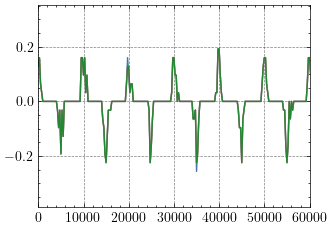

In [46]:
fig = plt.figure()
ax  = fig.add_subplot()
ax.plot(time_dict[amp][:-1]*1e9, currents_dict[amp][0].values)
ax.plot(time_dict[amp][:-1]*1e9, currents_dict[amp][1].values)
ax.plot(time_dict[amp][:-1]*1e9, currents_dict[amp][2].values)
ax.set_xlim(0,6e4)

### Temperature dependence

In [205]:
results_dict_T = {}
pots_dict_T    = {}
pots_d_dict_T  = {}
time_dict_T    = {}
amp            = 0.1

for TEMP in TEMPERATURE:

    # Voltages
    t,U = return_voltages(amp)

    # Simulation
    sim.run_var_voltages(voltages=U, time_steps=t, target_electrode=1, T_val=TEMP, save=False, stat_size=20)

    # Results
    results = pd.DataFrame(sim.return_output_values()[:,1:], columns=['steps','I','u_I'])
    pots    = pd.DataFrame(sim.return_potential_landscape())
    a, b    = sim.return_network_currents()
    currs   = pd.DataFrame(b, columns=a)

    time_dict_T[TEMP]       = t
    results_dict_T[TEMP]    = results
    pots_dict_T[TEMP]       = pots
    pots_diffs              = pots.iloc[:,[0,2,3,1]].copy()
    pots_diffs.columns      = [0,1,2,3]
    pots_diffs              = pots_diffs.diff(axis=1).dropna(axis=1)
    pots_d_dict_T[TEMP]     = pots_diffs

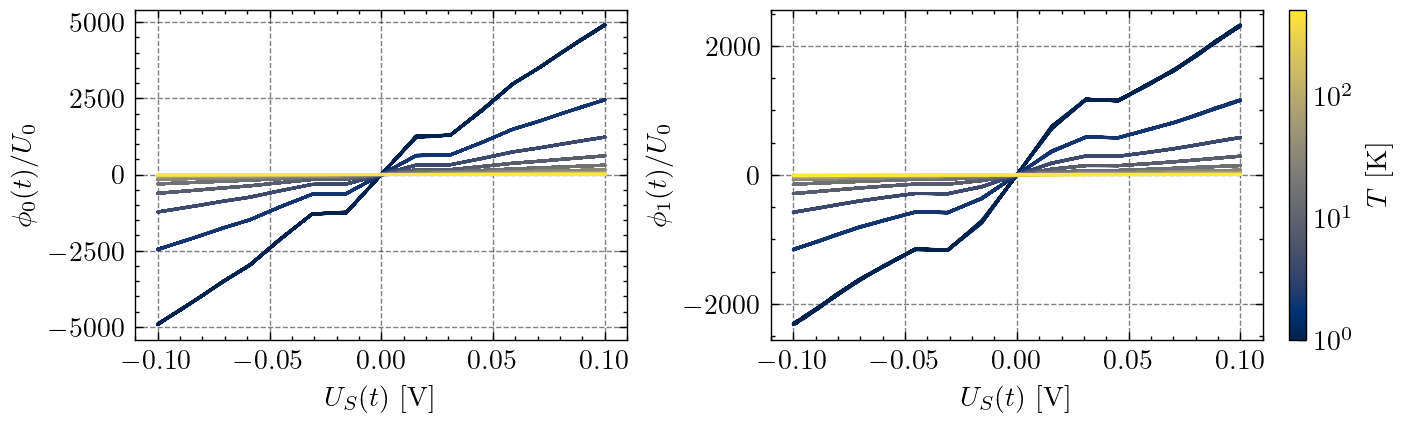

In [208]:
norm = LogNorm(vmin=min(TEMPERATURE), vmax=max(TEMPERATURE))

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2.0)
fig.set_figheight(fig.get_figheight()*0.8)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

for TEMP in TEMPERATURE:
    ax1.plot(pots_dict_T[TEMP].iloc[1000:,0],pots_dict_T[TEMP].iloc[1000:,2]/(sim.kb*TEMP), color=cm(norm(TEMP)))
    ax1.set_ylabel('$\phi_0(t)/U_0$')
    ax1.set_xlabel('$U_S(t)$ [V]')

    ax2.plot(pots_dict_T[TEMP].iloc[1000:,0],pots_dict_T[TEMP].iloc[1000:,3]/(sim.kb*TEMP), color=cm(norm(TEMP)))
    ax2.set_xlabel('$U_S(t)$ [V]')
    ax2.set_ylabel('$\phi_1(t)/U_0$')

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax2)
cbar.set_label("$T$ [K]")

Text(0.5, 0, '$t$ [ns]')

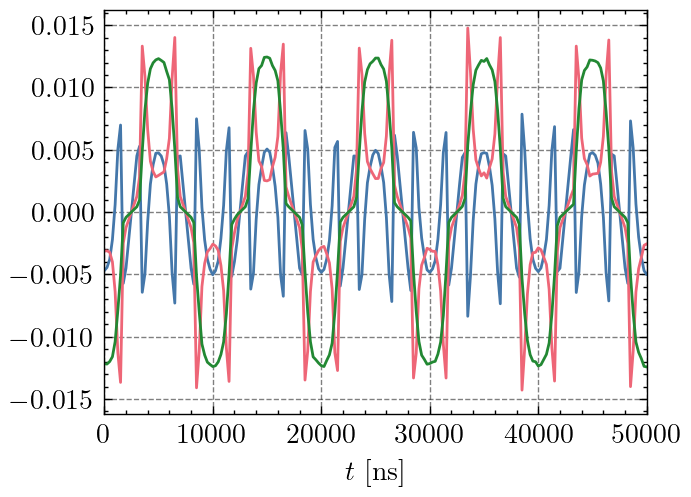

In [76]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(t[:-1]*1e9, pots_diffs.iloc[:,0])
ax.plot(t[:-1]*1e9, pots_diffs.iloc[:,1])
ax.plot(t[:-1]*1e9, pots_diffs.iloc[:,2])
# ax.plot(pots_diffs.iloc[:100,1])
# ax.plot(pots_diffs.iloc[:100,2])
ax.set_xlim(0,5e4)
ax.set_xlabel('$t$ [ns]')

Text(0.5, 0, '$t$ [ns]')

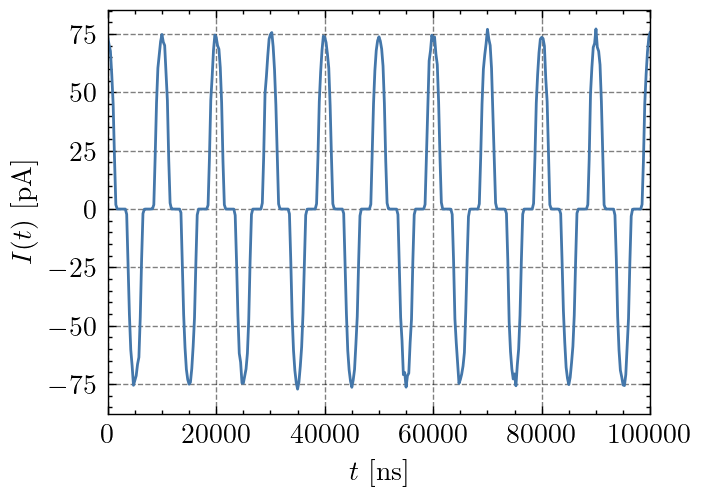

In [78]:
fig,ax = plt.subplots(dpi=200)
ax.plot(t[:-1]*1e9, results['I'])
ax.set_xlim(0,1e5)
ax.set_ylabel('$I(t)$ [pA]')
ax.set_xlabel('$t$ [ns]')

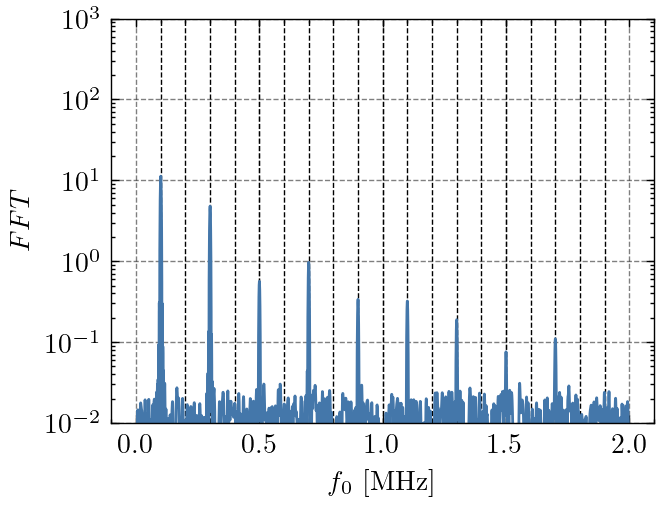

In [79]:
signal  = results['I'].values
xf, yf  = nanonets_utils.fft(signal=signal, dt=dt, n_padded=len(signal)*5, use_hann=True)

fig,ax = plt.subplots(dpi=200)
ax.plot(xf/1e6, yf)
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$FFT$")
ax.set_ylim(1e-2,1e3)
ax.set_yscale('log')
ax.vlines([i*f_0/1e6 for i in range(1,20)], 1e-2, 1e3, colors='black', linestyles='--', zorder=0.1, lw=0.5)

Text(0.5, 0, '$|I|$')

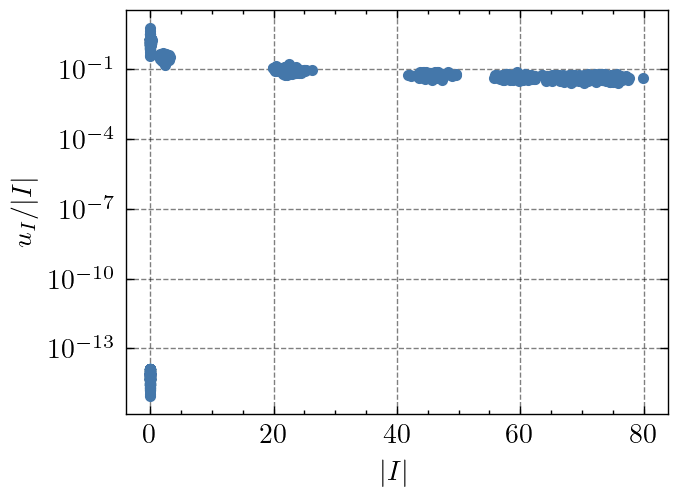

In [80]:
fig,ax  = plt.subplots(dpi=200)
ax.plot(results['I'].abs(),results['u_I']/results['I'].abs(),'.')
ax.set_yscale('log')
ax.set_ylabel('$u_I/|I|$')
ax.set_xlabel('$|I|$')

In [81]:
# FFT
ffts = []
for i in range(4):
    signal  = pots.iloc[:,i]
    xf, yf  = nanonets_utils.fft(signal=signal, dt=dt, n_padded=len(signal)*5, use_hann=True)
    ffts.append(yf)
ffts = pd.DataFrame(np.array(ffts).T)

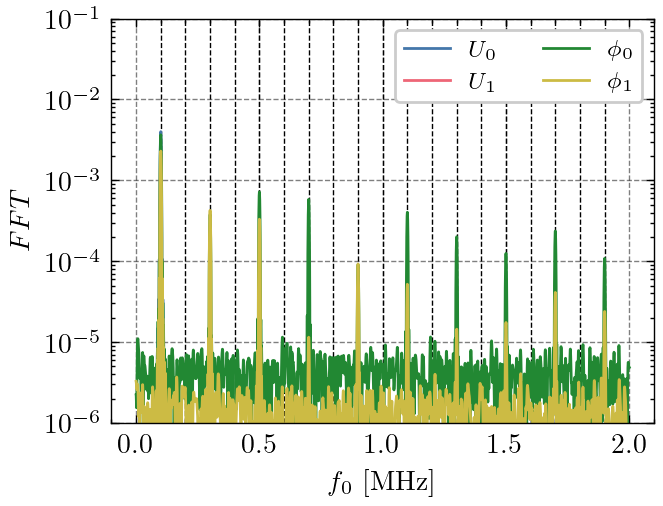

In [82]:
l       = ['$U_0$','$U_1$','$\phi_0$','$\phi_1$']
fig,ax  = plt.subplots(dpi=200)
for i in range(0,4):
    ax.plot(xf/1e6, ffts.iloc[:,i], label=l[i])
ax.set_yscale('log')
ax.legend(ncol=2, fontsize='small', loc='upper right')
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$FFT$")
ax.set_ylim(1e-6,1e-1)
ax.vlines([i*f_0/1e6 for i in range(1,20)], 1e-6, 1e-1, colors='black', linestyles='--', zorder=0.1, lw=0.5)

### Temperature dependency

In [83]:
def C_s(r):
    factor  = 4 * np.pi * 8.85418781762039e-3 * EPS_S
    cap     = factor * r
    return cap
def C_m(r1,r2):
    # Base factor
    d       = r1 + r2 + 1.0
    factor  = 4 * np.pi * 8.85418781762039e-3 * EPS_R * (r1 * r2) / d
    
    # Terms of the Taylor expansion
    term1       = 1.0
    term2       = (r1 * r2) / (d**2 - 2*r1*r2)
    denominator = d**4 - 4*(d**2)*r1*r2 + 3*(r1**2)*(r2**2)
    term3       = ((r1**2)*(r2**2)) / denominator
    cap         = factor * (term1 + term2 + term3)
                
    return cap

In [84]:
r1,r2   = 10.0, 10.0
C_S1    = C_m(r1,10.0)
C_12    = C_m(r1,r2)
C_2D    = C_m(r2,10.0)
C_1     = C_s(r1)
C_2     = C_s(r2)
D       = (C_S1+C_12+C_1)*(C_12+C_2D+C_2)-C_12**2
alpha   = C_S1*(C_12+C_2D+C_2)/D
beta    = C_S1*C_12/D

In [85]:
T_vals  = np.linspace(1,298,1000)
A_S1    = sim.const_capacitance_values[0]
A_12    = sim.const_capacitance_values[3]
A_2D    = sim.const_capacitance_values[4]
kBT     = sim.kb*T_vals

(0.0, 50.0)

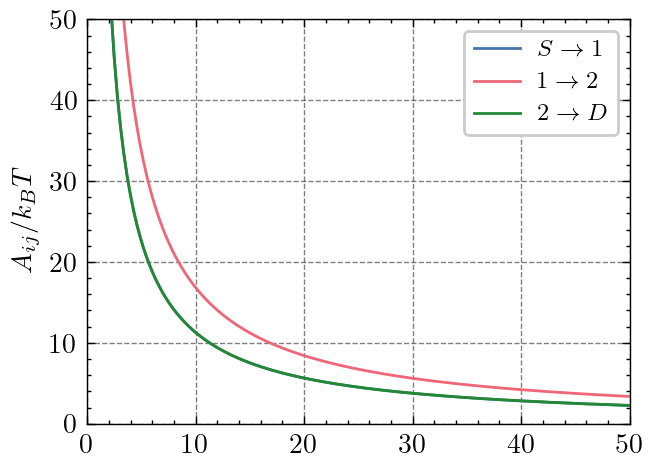

In [86]:
fig, ax = plt.subplots(dpi=200)
ax.plot(T_vals,A_S1/kBT, label='$S \\rightarrow 1$')
ax.plot(T_vals,A_12/kBT, label='$1 \\rightarrow 2$')
ax.plot(T_vals,A_2D/kBT, label='$2 \\rightarrow D$')
ax.set_ylabel("$A_{ij}/k_BT$")
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend(fontsize='small')
ax.set_xlim(0,50)
ax.set_ylim(0,50)

In [89]:
amps    = 0.02
B_S1    = np.abs(-sim.ele_charge*(alpha-1)*amps)
B_12    = np.abs(sim.ele_charge*(beta-alpha)*amps)
B_2D    = np.abs(-sim.ele_charge*beta*amps)

(0.0, 50.0)

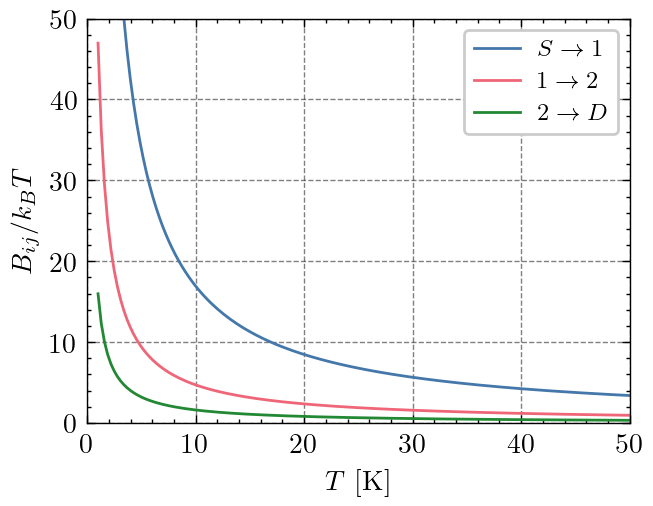

In [91]:
fig, ax = plt.subplots(dpi=200)
ax.plot(T_vals,B_S1/kBT, label='$S \\rightarrow 1$')
ax.plot(T_vals,B_12/kBT, label='$1 \\rightarrow 2$')
ax.plot(T_vals,B_2D/kBT, label='$2 \\rightarrow D$')
ax.set_xlabel("$T$ [K]")
ax.set_ylabel("$B_{ij}/k_BT$")
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend(fontsize='small')
ax.set_xlim(0,50)
ax.set_ylim(0,50)

In [92]:
B_S1    = -sim.ele_charge*(alpha-1)*amps
B_12    = sim.ele_charge*(beta-alpha)*amps
B_2D    = -sim.ele_charge*beta*amps

In [94]:
amp_vals    = np.logspace(-2.1,0,1000)#np.linspace(0.01,0.1,1000)
t_vals      = np.logspace(-0.5,2,1000)
B_vals_S1   = np.zeros((1000,1000))
B_vals_12   = np.zeros((1000,1000))
B_vals_2D   = np.zeros((1000,1000))

for i,amp_val in enumerate(amp_vals):
    for j,T_val in enumerate(t_vals):
        B_vals_S1[i,j] = np.abs(sim.ele_charge*(alpha-1)*amp_val/(sim.kb*T_val))
        B_vals_12[i,j] = np.abs(sim.ele_charge*(beta-alpha)*amp_val/(sim.kb*T_val))
        B_vals_2D[i,j] = np.abs(sim.ele_charge*beta*amp_val/(sim.kb*T_val))

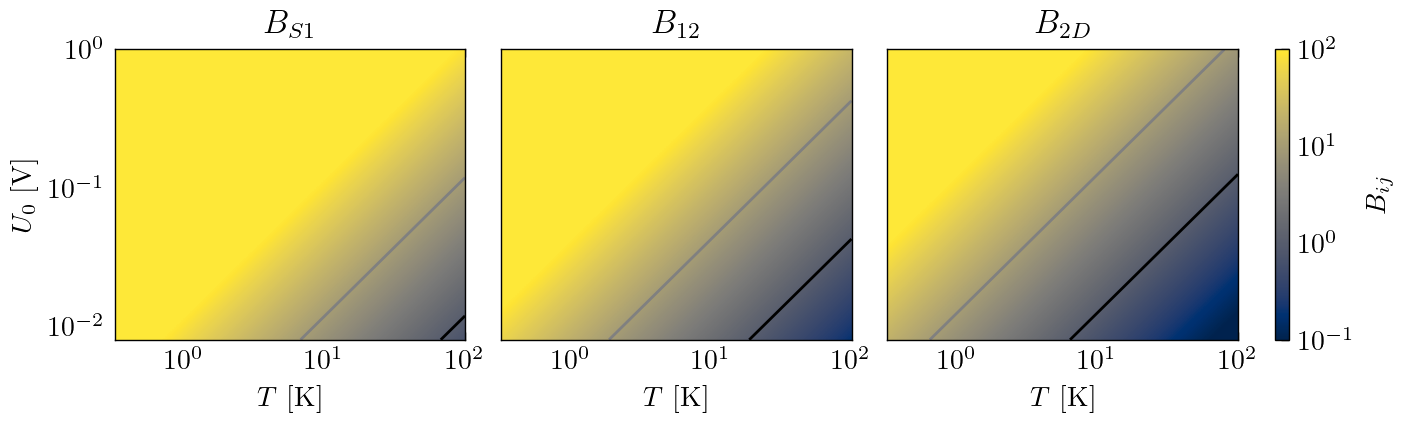

In [97]:
# 1) Build a meshgrid (centers or edges) for pcolormesh:
TT, AA = np.meshgrid(t_vals, amp_vals)  # both shape = (1000, 1000)

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
fig.set_figheight(fig.get_figheight()*0.8)

# Plot B_vals_S1:
ax1 = fig.add_subplot(1, 3, 1)
pcm1 = ax1.pcolormesh(
    TT, AA, B_vals_S1,
    norm=LogNorm(vmin=1e-1, vmax=1e2),
    shading='auto', cmap='cividis'
)
# Contour where B = 1:
cs1 = ax1.contour(TT, AA, B_vals_S1, levels=[1.0], colors='black', linewidths=1.0)
cs1 = ax1.contour(TT, AA, B_vals_S1, levels=[10.0], colors='grey', linewidths=1.0)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("$T$ [K]")
ax1.set_ylabel("$U_0$ [V]")
ax1.set_title("$B_{S1}$")

# Plot B_vals_12:
ax2 = fig.add_subplot(1, 3, 2)
pcm2 = ax2.pcolormesh(
    TT, AA, B_vals_12,
    norm=LogNorm(vmin=1e-1, vmax=1e2),
    shading='auto', cmap='cividis'
)
cs2 = ax2.contour(TT, AA, B_vals_12, levels=[1.0], colors='black', linewidths=1.0)
cs2 = ax2.contour(TT, AA, B_vals_12, levels=[10.0], colors='grey', linewidths=1.0)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("$T$ [K]")
ax2.set_title("$B_{12}$")
ax2.set_yticklabels("")

# Plot B_vals_2D:
ax3 = fig.add_subplot(1, 3, 3)
pcm3 = ax3.pcolormesh(
    TT, AA, B_vals_2D,
    norm=LogNorm(vmin=1e-1, vmax=1e2),
    shading='auto', cmap='cividis'
)
cs3 = ax3.contour(TT, AA, B_vals_2D, levels=[1.0], colors='black', linewidths=1.0)
cs3 = ax3.contour(TT, AA, B_vals_2D, levels=[10.0], colors='grey', linewidths=1.0)
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_xlabel("$T$ [K]")
ax3.set_title("$B_{2D}$")
ax3.set_yticklabels("")

# Colorbar (shared):
cbar = fig.colorbar(pcm3, orientation='vertical')
cbar.set_label("$B_{ij}$")

### 2 NP Device of unequal NP-Size

In [319]:
np2     = {'np_index': [1],
        'mean_radius': 1e7,
        'std_radius': 0.0}
sim2    = nanonets.simulation(topo, np_info2=np2)

In [320]:
# Simulation
sim2.run_var_voltages(voltages=U, time_steps=t, target_electrode=1, T_val=5.0, save=False, stat_size=20)

In [327]:
# Results
results2 = pd.DataFrame(sim2.return_output_values()[:,1:], columns=['steps','I','u_I'])
pots2    = pd.DataFrame(sim2.return_potential_landscape())
a, b     = sim2.return_network_currents()
currs2   = pd.DataFrame(b, columns=a)

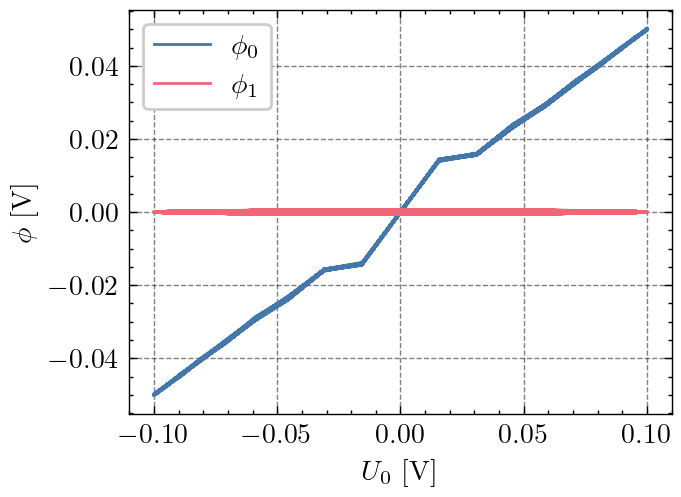

In [328]:
fig,ax = plt.subplots(dpi=200)
ax.plot(pots2.iloc[:,0],pots2.iloc[:,2], label='$\phi_0$')
ax.plot(pots2.iloc[:,0],pots2.iloc[:,3], label='$\phi_1$')
ax.set_xlabel('$U_0$ [V]')
ax.set_ylabel('$\phi$ [V]')
ax.legend()

Text(0.5, 0, '$t$ [ns]')

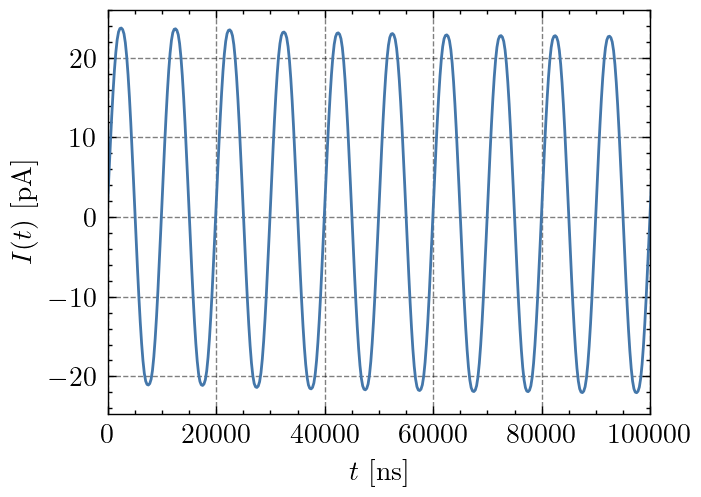

In [329]:
fig,ax = plt.subplots(dpi=200)
ax.plot(t[:-1]*1e9, results2['I'])
ax.set_xlim(0,1e5)
ax.set_ylabel('$I(t)$ [pA]')
ax.set_xlabel('$t$ [ns]')

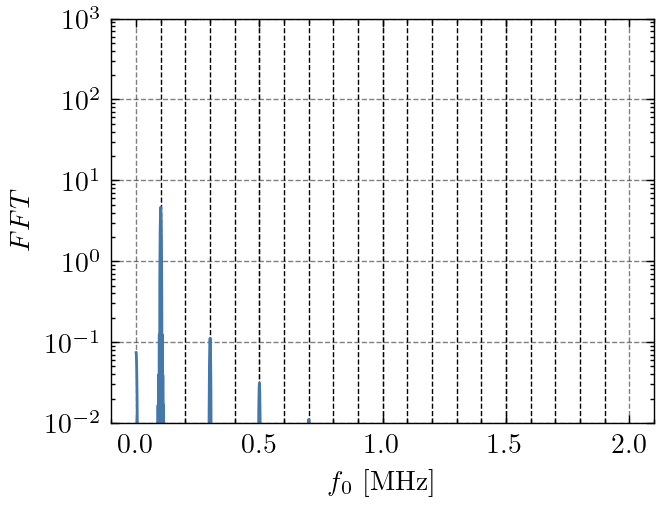

In [333]:
signal  = results2['I'].values
xf, yf  = nanonets_utils.fft(signal=signal, dt=dt, n_padded=len(signal)*5, use_hann=True)

fig,ax = plt.subplots(dpi=200)
ax.plot(xf/1e6, yf)
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$FFT$")
ax.set_ylim(1e-2,1e3)
ax.set_yscale('log')
ax.vlines([i*f_0/1e6 for i in range(1,20)], 1e-2, 1e3, colors='black', linestyles='--', zorder=0.1, lw=0.5)

Text(0.5, 0, '$|I|$')

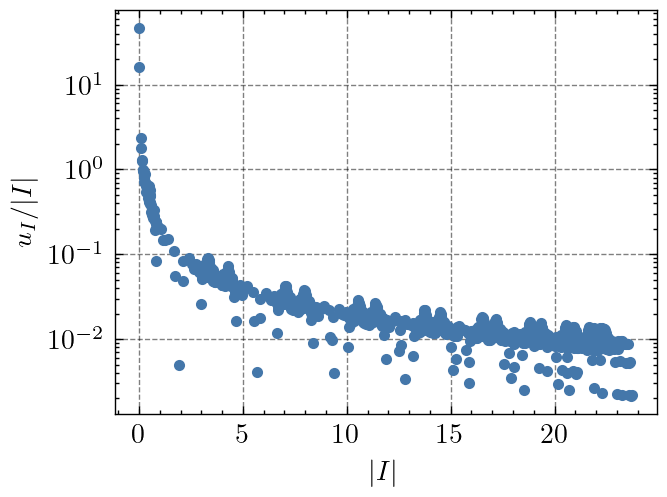

In [334]:
fig,ax  = plt.subplots(dpi=200)
ax.plot(results2['I'].abs(),results2['u_I']/results2['I'].abs(),'.')
ax.set_yscale('log')
ax.set_ylabel('$u_I/|I|$')
ax.set_xlabel('$|I|$')

In [335]:
# FFT
ffts = []
for i in range(4):
    signal  = pots2.iloc[:,i]
    xf, yf  = nanonets_utils.fft(signal=signal, dt=dt, n_padded=len(signal)*5, use_hann=True)
    ffts.append(yf)
ffts = pd.DataFrame(np.array(ffts).T)

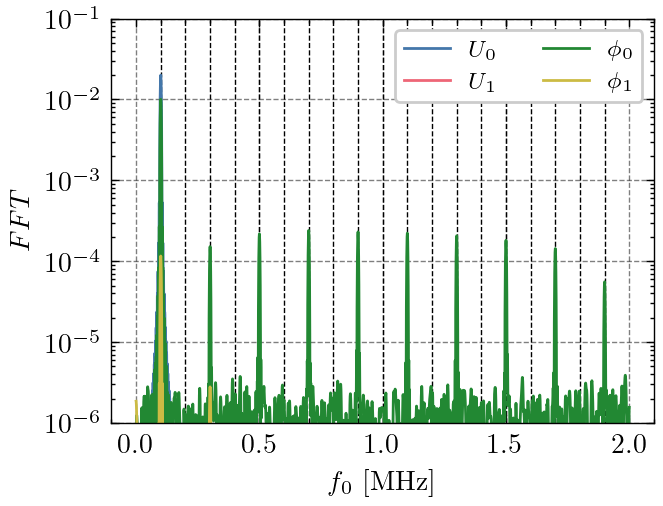

In [336]:
l       = ['$U_0$','$U_1$','$\phi_0$','$\phi_1$']
fig,ax  = plt.subplots(dpi=200)
for i in range(0,4):
    ax.plot(xf/1e6, ffts.iloc[:,i], label=l[i])
ax.set_yscale('log')
ax.legend(ncol=2, fontsize='small', loc='upper right')
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$FFT$")
ax.set_ylim(1e-6,1e-1)
ax.vlines([i*f_0/1e6 for i in range(1,20)], 1e-6, 1e-1, colors='black', linestyles='--', zorder=0.1, lw=0.5)